# Capstone 1 In Depth Analysis

### Data Cleaning

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.metrics import balanced_accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import sklearn
from sklearn.metrics import fbeta_score

In [2]:
#import in data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv'

base = pd.read_csv(url)

In [3]:
#change the columns with numeric values to numeric (specifically Age,
# HoursPerWeek, and TotalHours)
base['Age']=pd.to_numeric(base['Age'], errors = 'coerce')
base['HoursPerWeek']=pd.to_numeric(base['HoursPerWeek'], errors = 'coerce')
base['TotalHours']=pd.to_numeric(base['TotalHours'], errors = 'coerce')

In [4]:
#clean only outliers, keeping the NaNs of the pro subset
base2 = base.set_index('TotalHours')
base2 = base2.drop(1000000, axis=0)
base2 = base2.reset_index()
#remove Gap Betweeb PACs outlier
base2 = base2.set_index('GapBetweenPACs')
base2 = base2.drop(237.142900, axis=0)
base2 = base2.reset_index()

### Create the Data Sets Needed

In [5]:
league_names = ['12','23','34','45','56','67']
league_dict = {}
for name in league_names:
    a = int(name[0])
    b = int(name[1])
    league_dict.update({name : {'full' : base2[base2['LeagueIndex'].between(a,b)].dropna(axis=0)}})

In [6]:
#build 78 separately so that the columns with nas are dropped, rather than the rows,
#as it deletes too much in the previous leagues
league_dict.update({'78': {'full': base2[base2['LeagueIndex'].between(7,8)].dropna(axis=1)}})
#reassign league_names for rest of  time
league_names = ['12','23','34','45','56','67','78']

In [7]:
for name in league_names :
    league_dict[name]['X'] = league_dict[name]['full'].drop('LeagueIndex', axis=1)
    league_dict[name]['y'] = league_dict[name]['full']['LeagueIndex']                 

# VIF Testing

Create new VIF testing around the idea of largest number of collinearities

In [8]:
def vif_testing(full_set, vif_crit) :
    """Produce a set where all features have a VIF below the given threshold value. Returns Dropped Variables and current VIF"""
    test_set = full_set
    crit_test = vif_crit + 2
    highest_corr = 'LeagueIndex'
    dropped_vars = []
    while crit_test > vif_crit :
        dropped_vars.append(highest_corr)
        test_set = test_set.drop(highest_corr, axis = 1)
        vif = pd.DataFrame()
        vif['variables'] = test_set.columns
        vif['VIF']=[variance_inflation_factor(test_set.values, i)
                   for i in range(test_set.shape[1])]
        crit_test = vif.max()[1]
        vif_pull = vif[vif['VIF'] == vif.max()[1]]
        vif_name = np.array(vif_pull['variables'])[0]
        highest_corr = vif_name
    dropped_vars.remove('LeagueIndex')
    return dropped_vars, vif

In [9]:
def vif_store_plot(vif_crit):
    temp = {}
    for name in league_names:
        a, b = vif_testing(league_dict[name]['full'],vif_crit)
        temp.update({name : {'Dropped':a, 'VIF':b}})
    for name in league_names :
        league_dict[name].update({vif_crit: temp[name]})
    vif_dfs = [temp['12']['VIF'], temp['23']['VIF'], temp['34']['VIF'], temp['45']['VIF'],
          temp['56']['VIF'], temp['67']['VIF'], temp['78']['VIF']]
    VIF_df = pd.concat(vif_dfs, keys=league_names)
    VIF_df = VIF_df.reset_index()
    VIF_df = VIF_df.drop('level_1', axis=1)
    VIF_df.columns = ['LeagueName','Variables','VIF']
    plt.figure(figsize=(12,10))
    graph = sns.lineplot(x='LeagueName',y='VIF',hue='Variables', data=VIF_df)
    graph = plt.title('VIF of features across the League Transitions')
    return VIF_df, graph

(   LeagueName             Variables       VIF
 0          12        GapBetweenPACs  4.352313
 1          12            TotalHours  2.394999
 2          12                GameID  3.776857
 3          12          HoursPerWeek  2.972653
 4          12       SelectByHotkeys  2.457400
 5          12       AssignToHotkeys  4.160134
 6          12         UniqueHotkeys  3.600347
 7          12        MinimapAttacks  1.314459
 8          12    MinimapRightClicks  1.953403
 9          12           WorkersMade  4.288960
 10         12      ComplexUnitsMade  1.778912
 11         12  ComplexAbilitiesUsed  1.818733
 12         23        GapBetweenPACs  4.686518
 13         23            TotalHours  1.787321
 14         23                GameID  3.784897
 15         23          HoursPerWeek  2.972271
 16         23       SelectByHotkeys  2.233814
 17         23       AssignToHotkeys  4.103301
 18         23         UniqueHotkeys  3.592029
 19         23        MinimapAttacks  1.337087
 20         2

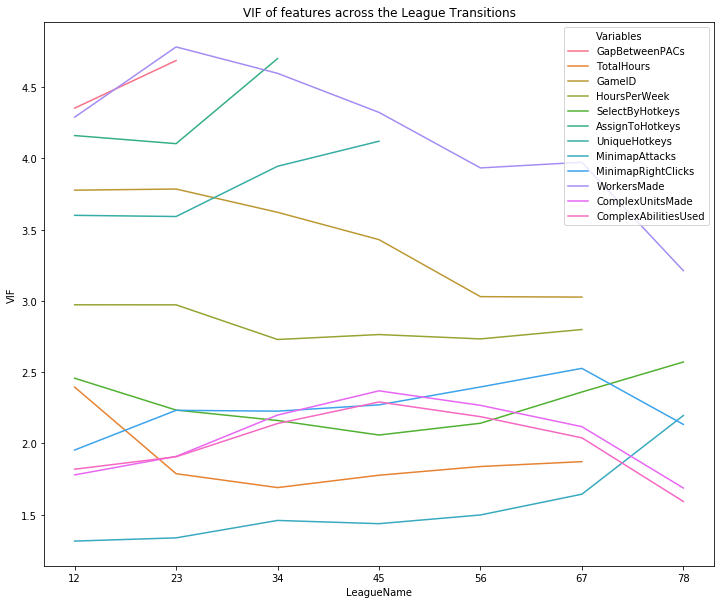

In [10]:
vif_store_plot(5)

(   LeagueName             Variables       VIF
 0          12            TotalHours  2.192078
 1          12          HoursPerWeek  2.402876
 2          12       SelectByHotkeys  1.624396
 3          12        MinimapAttacks  1.276608
 4          12    MinimapRightClicks  1.716128
 5          12      ComplexUnitsMade  1.753566
 6          12  ComplexAbilitiesUsed  1.803894
 7          23            TotalHours  1.748136
 8          23          HoursPerWeek  2.481900
 9          23       SelectByHotkeys  1.887298
 10         23         UniqueHotkeys  2.483480
 11         23        MinimapAttacks  1.319295
 12         23    MinimapRightClicks  2.065124
 13         23      ComplexUnitsMade  1.871743
 14         23  ComplexAbilitiesUsed  1.892608
 15         34            TotalHours  1.656305
 16         34          HoursPerWeek  2.191812
 17         34       SelectByHotkeys  1.720312
 18         34        MinimapAttacks  1.407730
 19         34    MinimapRightClicks  1.900270
 20         3

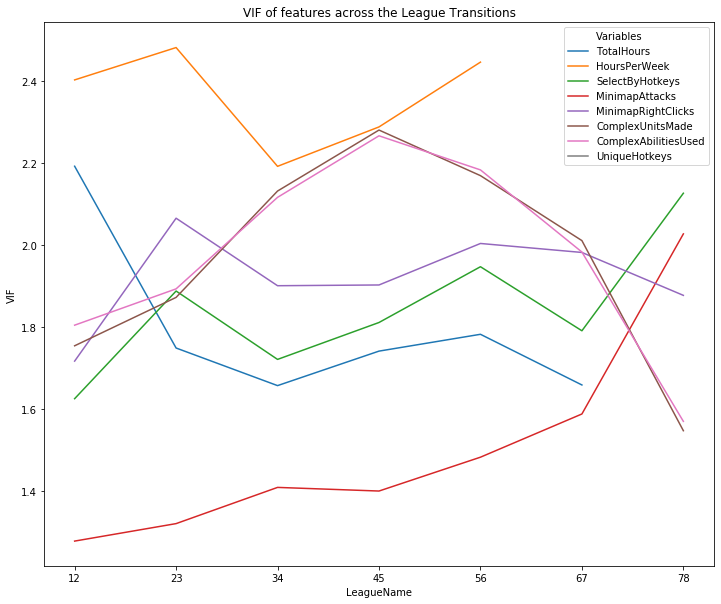

In [11]:
vif_store_plot(2.5)

## Logistic Regression

In [12]:
for name in league_names:
    a,b,c,d = train_test_split(league_dict[name]['X'],league_dict[name]['y'], random_state=0, stratify=league_dict[name]['y'])
    league_dict[name].update({'X_train':a,'X_test':b,'y_train':c,'y_test':d})

In [13]:
#normalize all of the training data based on itself, and the testing data based on the training data
means_std_dict = {}
for name in league_names:
    col_names = league_dict[name]['X_train'].columns
    means_std_dict.update({name:col_names})
    col_info = {}
    for col in col_names:
        col_mean = league_dict[name]['X_train'][col].mean()
        col_std = league_dict[name]['X_train'][col].std()
        league_dict[name]['X_train'][col]= league_dict[name]['X_train'][col].map(lambda x: (x-col_mean)/col_std)
        col_info.update({col: {'mean':col_mean, 'std':col_std}})
    means_std_dict.update({name:col_info})

C:\Users\sagun\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [14]:
#apply the normalization to the new data set, assuming the previous data has the same distribution
for name in league_names:
    col_names = league_dict[name]['X_test'].columns
    for col in col_names:
        col_mean = means_std_dict[name][col]['mean']
        col_std = means_std_dict[name][col]['std']
        league_dict[name]['X_test'][col]= league_dict[name]['X_test'][col].map(lambda x: (x-col_mean)/col_std)

C:\Users\sagun\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [15]:
#Build the subsets under the [5] and [2.5] keys in the dictionaries
vif_regions = [5, 2.5]
for name in league_names:
    league_dict[name].update({'ori':{'X_train':league_dict[name]['X_train'],
                                    'X_test':league_dict[name]['X_test']}})
for region in vif_regions :
    for name in league_names:
        league_dict[name][region].update({'X_train':league_dict[name]['X_train'].drop(league_dict[name][region]['Dropped'], axis=1),
                                         'X_test':league_dict[name]['X_test'].drop(league_dict[name][region]['Dropped'], axis=1)})

In [16]:
lr_regions = ['ori',5,2.5]
for name in league_names:
    for region in lr_regions:
        min_val = league_dict[name]['y_train'].min()
        league_dict[name][region].update({'y_train':league_dict[name]['y_train']-min_val,
                                          'y_test':league_dict[name]['y_test']-min_val})

In [17]:
for name in league_names:
    for region in lr_regions:
        league_dict[name][region].update({'reg' : sm.Logit(endog=league_dict[name][region]['y_train'],
                                                           exog=league_dict[name][region]['X_train'])})

In [18]:
league_names_no78 = ['12','23','34','45','56','67']
for name in league_names_no78:
    for region in lr_regions:
        league_dict[name][region].update({'result': league_dict[name][region]['reg'].fit(method='newton', maxiter=100)})


Optimization terminated successfully.
         Current function value: 0.631543
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.638817
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667501
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.619709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.628281
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646207
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.639144
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663950
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670963
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588698
  

In [19]:
#build 78 models using 'lbfgs' instead of newton, as newton does not converge
for region in lr_regions:
    league_dict['78'][region].update({'result': league_dict['78'][region]['reg'].fit(method='lbfgs', maxiter=100)})


In [20]:
for name in league_names:
    for region in lr_regions:
        league_dict[name][region].update({'proba':league_dict[name][region]['reg'].predict(league_dict[name][region]['result'].params, 
                                                                                          exog=league_dict[name][region]['X_test'])})

### Check for best Threshold value

In [21]:
def thresholds_full():
    for name in league_names:
        for region in lr_regions :
            pred_proba_df = pd.DataFrame(league_dict[name][region]['proba'])
            threshold_list = np.arange(0,1.01,0.01)
            best_threshold = 0
            best_accuracy=0
            temp_dict = {}
            for i in threshold_list:
                Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
                test_accuracy = balanced_accuracy_score(Y_test_pred, league_dict[name][region]['y_test'])
                if test_accuracy>best_accuracy :
                    best_threshold = i
                    best_accuracy = test_accuracy
            print('\n League: {0}, Best Threshold in {1} at {2} with an Accuracy of {3}'.format(name,region,best_threshold, best_accuracy))

In [22]:
thresholds_full()

C:\Users\sagun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')



 League: 12, Best Threshold in ori at 0.1 with an Accuracy of 0.8452380952380952

 League: 12, Best Threshold in 5 at 0.74 with an Accuracy of 0.675

 League: 12, Best Threshold in 2.5 at 0.34 with an Accuracy of 0.83984375

 League: 23, Best Threshold in ori at 0.18 with an Accuracy of 0.8136363636363637

 League: 23, Best Threshold in 5 at 0.17 with an Accuracy of 0.8108108108108107

 League: 23, Best Threshold in 2.5 at 0.88 with an Accuracy of 0.6986301369863014

 League: 34, Best Threshold in ori at 0.07 with an Accuracy of 0.8002958579881656

 League: 34, Best Threshold in 5 at 0.8 with an Accuracy of 0.7072072072072072

 League: 34, Best Threshold in 2.5 at 0.35000000000000003 with an Accuracy of 0.7985294117647059

 League: 45, Best Threshold in ori at 0.88 with an Accuracy of 0.7550251256281407

 League: 45, Best Threshold in 5 at 0.9 with an Accuracy of 0.7543859649122807

 League: 45, Best Threshold in 2.5 at 0.91 with an Accuracy of 0.7537499999999999

 League: 56, Best Th

# Look at coefficeint values of important coefficients across best models with VIF

In [23]:
#label sets
best_model = {'12':2.5, '23':5, '34':2.5, '45':5, '56':2.5, '67':2.5, '78':2.5}
coeff_VIF_dict = {}

In [24]:
#build VIF and Coeffcient Values dataset
for name in league_names:
    param_coeff = pd.DataFrame(league_dict[name][best_model[name]]['result'].params)
    param_coeff = param_coeff.reset_index()
    param_coeff.columns = ['variables','Params Coeff']
    param_coeff_VIF = pd.merge(league_dict[name][best_model[name]]['VIF'],param_coeff, on='variables')
    coeff_VIF_dict.update({name:param_coeff_VIF})

In [25]:
#correct form
param_coeff_VIF = [coeff_VIF_dict['12'], coeff_VIF_dict['23'], coeff_VIF_dict['34'], coeff_VIF_dict['45'], 
                  coeff_VIF_dict['56'], coeff_VIF_dict['67'], coeff_VIF_dict['78']]
param_coeff_VIF = pd.concat(param_coeff_VIF, keys=league_names)
param_coeff_VIF = param_coeff_VIF.reset_index()
param_coeff_VIF = param_coeff_VIF.drop('level_1', axis=1)
param_coeff_VIF.columns = ['LeagueName','Variables','VIF', 'Parameter Coefficients']

In [26]:
#select important variables
coeff_dict2 = {}
for name in league_names:
    sel_coeff = coeff_VIF_dict[name]
    sel_coeff = sel_coeff.set_index('variables')
    sel_coeff = sel_coeff.loc[['SelectByHotkeys','MinimapAttacks','MinimapRightClicks','ComplexUnitsMade','ComplexAbilitiesUsed']]
    sel_coeff = sel_coeff.reset_index()
    coeff_dict2.update({name:sel_coeff})

In [27]:
#build confidence intervals
confint_coeff = {}
for name in league_names:
    conf_int = league_dict[name][best_model[name]]['result'].conf_int()
    conf_int.columns = ['lower','upper']
    conf_int = conf_int.to_dict()
    confint_coeff.update({name:conf_int})

In [28]:
#separate and build by important variables
sbh_data = {}
ma_data = {}
mrc_data = {}
comum_data = {}
cau_data = {}

for name in league_names:
    sbh_data.update({name:{'lower':confint_coeff[name]['lower']['SelectByHotkeys'],
                          'upper':confint_coeff[name]['upper']['SelectByHotkeys']}})
    ma_data.update({name:{'lower':confint_coeff[name]['lower']['MinimapAttacks'],
                         'upper':confint_coeff[name]['upper']['MinimapAttacks']}})
    mrc_data.update({name:{'lower':confint_coeff[name]['lower']['MinimapRightClicks'],
                          'upper':confint_coeff[name]['upper']['MinimapRightClicks']}})
    comum_data.update({name:{'lower':confint_coeff[name]['lower']['ComplexUnitsMade'],
                            'upper':confint_coeff[name]['upper']['ComplexUnitsMade']}})
    cau_data.update({name:{'lower':confint_coeff[name]['lower']['ComplexAbilitiesUsed'],
                          'upper':confint_coeff[name]['upper']['ComplexAbilitiesUsed']}})

In [29]:
#function to correctly label and build dataframes for variables
def prep_and_merge(dict1, df1):
    a = pd.DataFrame.from_dict(dict1, orient='index').reset_index()
    a.columns = ['LeagueName', 'lower','upper']
    a = pd.merge(a,df1)
    a['lower']=a['Parameter Coefficients']-a['lower']
    a['upper']=a['upper']-a['Parameter Coefficients']
    return a

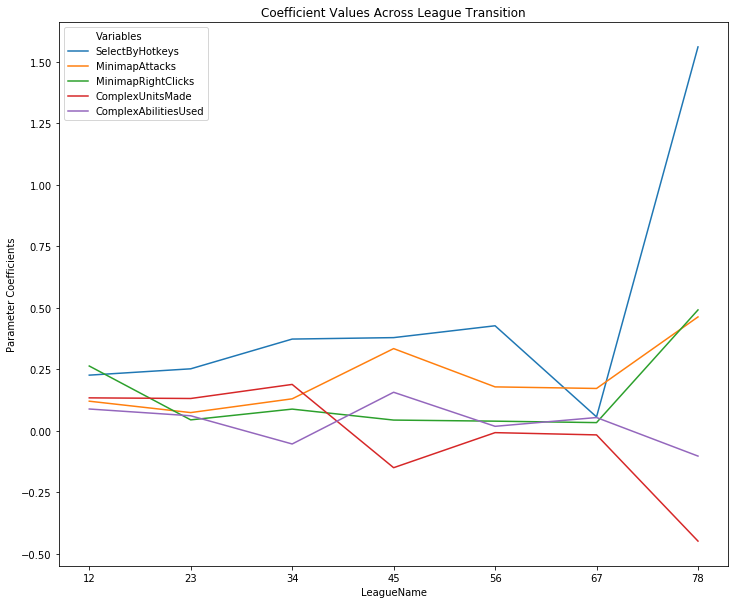

In [30]:
#plot all values
coeff_dfs = [coeff_dict2['12'], coeff_dict2['23'], coeff_dict2['34'], coeff_dict2['45'],
          coeff_dict2['56'], coeff_dict2['67'], coeff_dict2['78']]
coeff_vif_df = pd.concat(coeff_dfs, keys=league_names)
coeff_vif_df = coeff_vif_df.reset_index()
coeff_vif_df = coeff_vif_df.drop('level_1', axis=1)
coeff_vif_df.columns = ['LeagueName','Variables','VIF', 'Parameter Coefficients']
plt.figure(figsize=(12,10))
coeff_vif_plot = sns.lineplot(x='LeagueName',y='Parameter Coefficients',hue='Variables', data=coeff_vif_df)
coeff_vif_plot = plt.title('Coefficient Values Across League Transition')

In [31]:
#rebuild confidence intervals
confint_dfs = [pd.DataFrame(confint_coeff['12']), pd.DataFrame(confint_coeff['23']),
               pd.DataFrame(confint_coeff['34']), pd.DataFrame(confint_coeff['45']),
               pd.DataFrame(confint_coeff['56']), pd.DataFrame(confint_coeff['67']),
               pd.DataFrame(confint_coeff['78'])]
confint_vif_df = pd.concat(confint_dfs, keys=league_names)
confint_vif_df = confint_vif_df.reset_index()
confint_vif_df.columns = ['LeagueName','Variables','lower', 'upper']

In [32]:
#cleaning
confintcoeff_df = pd.merge(confint_vif_df, param_coeff_VIF, on=['LeagueName','Variables'])
confintcoeff_df['lower'] = confintcoeff_df['Parameter Coefficients']-confintcoeff_df['lower']
confintcoeff_df['upper'] = confintcoeff_df['upper']-confintcoeff_df['Parameter Coefficients']

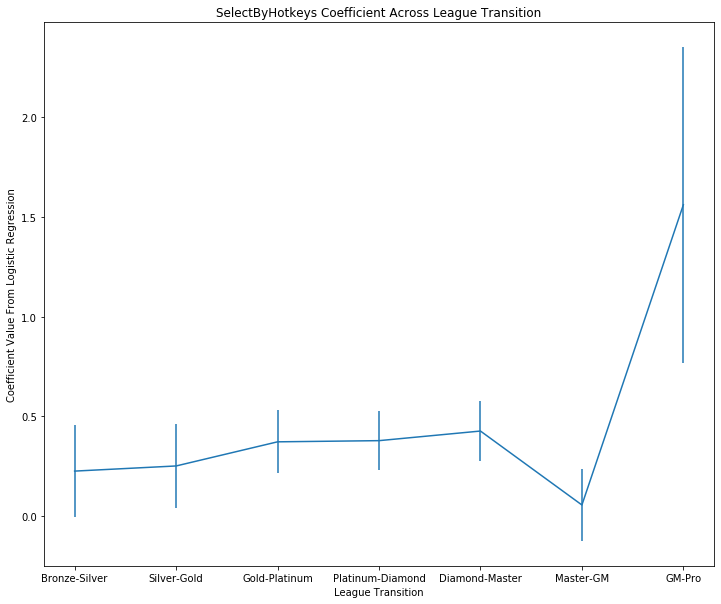

In [84]:
#select by hotkeys plot
league_trans_name = ['Bronze-Silver','Silver-Gold','Gold-Platinum','Platinum-Diamond','Diamond-Master',
                    'Master-GM','GM-Pro']
select_only = coeff_vif_df[coeff_vif_df['Variables']=='SelectByHotkeys']
select_only = prep_and_merge(sbh_data,select_only)
plt.figure(figsize=(12,10))
selectby_plot = plt.errorbar(select_only['LeagueName'],select_only['Parameter Coefficients'],
                             yerr = [select_only['lower'],select_only['upper']])
selectby_plot = plt.title('SelectByHotkeys Coefficient Across League Transition')
selectby_plot = plt.xticks(select_only['LeagueName'],league_trans_name)
selectby_plot = plt.xlabel('League Transition')
selectby_plot = plt.ylabel('Coefficient Value From Logistic Regression')

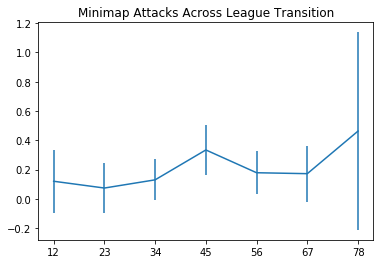

In [34]:
#minimap attacks plot
attacks_only = coeff_vif_df[coeff_vif_df['Variables']=='MinimapAttacks']
attacks_only = prep_and_merge(ma_data,attacks_only)
miniattack_plot = plt.errorbar(attacks_only['LeagueName'],attacks_only['Parameter Coefficients'],
                             yerr = [attacks_only['lower'], attacks_only['upper']])
miniattack_plot = plt.title('Minimap Attacks Across League Transition')

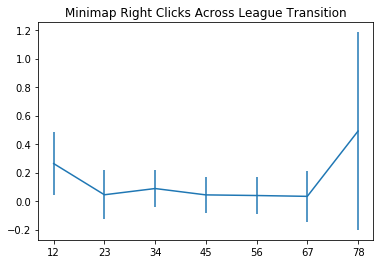

In [35]:
#minimap right clicks plot
right_only = coeff_vif_df[coeff_vif_df['Variables']=='MinimapRightClicks']
right_only = prep_and_merge(mrc_data,right_only)
rightclick_plot = plt.errorbar(right_only['LeagueName'],right_only['Parameter Coefficients'],
                             yerr = [right_only['lower'], right_only['upper']])
rightclick_plot = plt.title('Minimap Right Clicks Across League Transition')

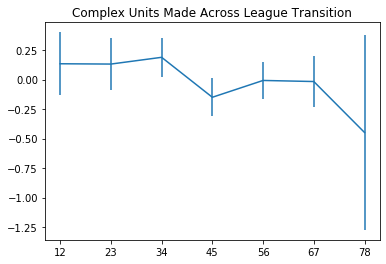

In [36]:
#complex units made plot
units_only = coeff_vif_df[coeff_vif_df['Variables']=='ComplexUnitsMade']
units_only = prep_and_merge(comum_data,units_only)
unitsmade_plot = plt.errorbar(units_only['LeagueName'],units_only['Parameter Coefficients'],
                             yerr = [units_only['lower'], units_only['upper']])
unitsmade_plot = plt.title('Complex Units Made Across League Transition')

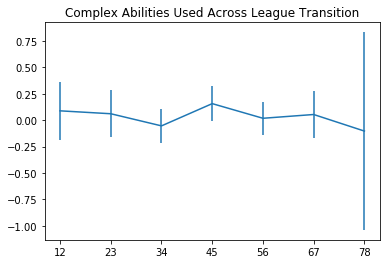

In [37]:
#complex abilities used plot
used_only = coeff_vif_df[coeff_vif_df['Variables']=='ComplexAbilitiesUsed']
used_only = prep_and_merge(cau_data,used_only)
used_plot = plt.errorbar(used_only['LeagueName'],used_only['Parameter Coefficients'],
                             yerr = [used_only['lower'], used_only['upper']])
used_plot = plt.title('Complex Abilities Used Across League Transition')

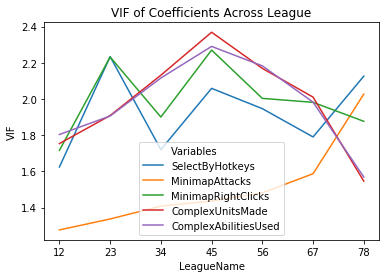

In [38]:
#VIF values across transitions
coeff_vif_plot2 = sns.lineplot(x='LeagueName',y='VIF',hue='Variables', data=coeff_vif_df)
coeff_vif_plot2 = plt.title('VIF of Coefficients Across League')

##### Coefficient plots per league, looking for highly indicative variables

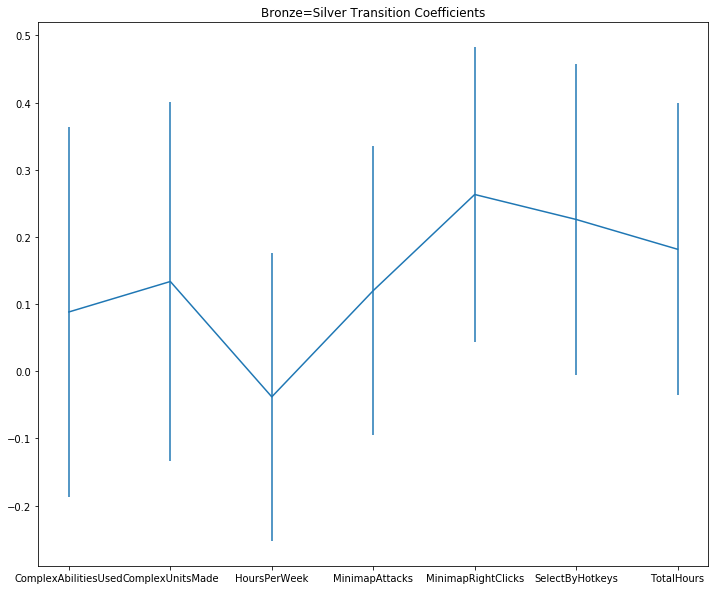

In [39]:
league12_build = confintcoeff_df[confintcoeff_df['LeagueName']=='12']
plt.figure(figsize=(12,10))
league12_coeff_plot = plt.errorbar(league12_build['Variables'],league12_build['Parameter Coefficients'],
                             yerr = [league12_build['lower'], league12_build['upper']])
league12_coeff_plot = plt.title('Bronze=Silver Transition Coefficients')

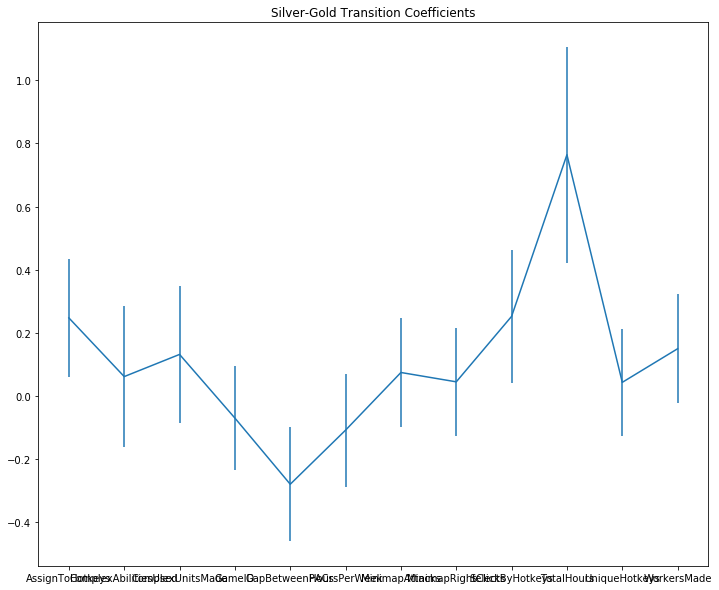

In [40]:
league23_build = confintcoeff_df[confintcoeff_df['LeagueName']=='23']
plt.figure(figsize=(12,10))
league23_coeff_plot = plt.errorbar(league23_build['Variables'],league23_build['Parameter Coefficients'],
                             yerr = [league23_build['lower'], league23_build['upper']])
league23_coeff_plot = plt.title('Silver-Gold Transition Coefficients')

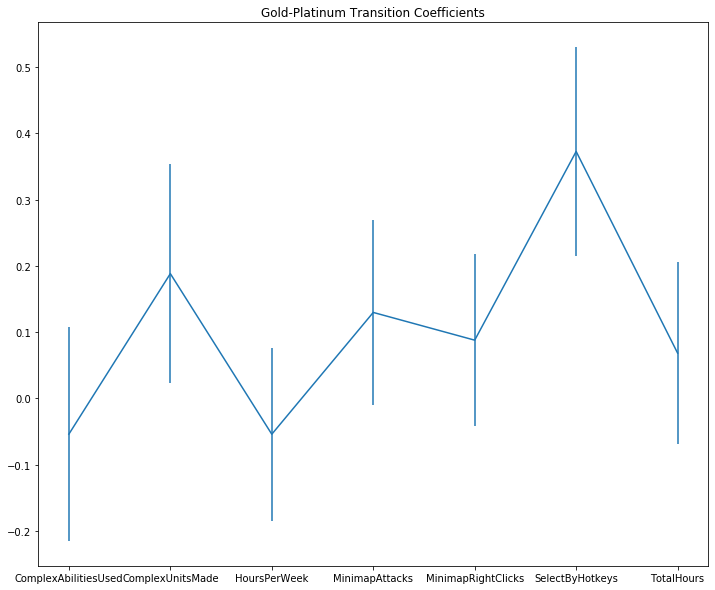

In [41]:
league34_build = confintcoeff_df[confintcoeff_df['LeagueName']=='34']
plt.figure(figsize=(12,10))
league34_coeff_plot = plt.errorbar(league34_build['Variables'],league34_build['Parameter Coefficients'],
                             yerr = [league34_build['lower'], league34_build['upper']])
league34_coeff_plot = plt.title('Gold-Platinum Transition Coefficients')

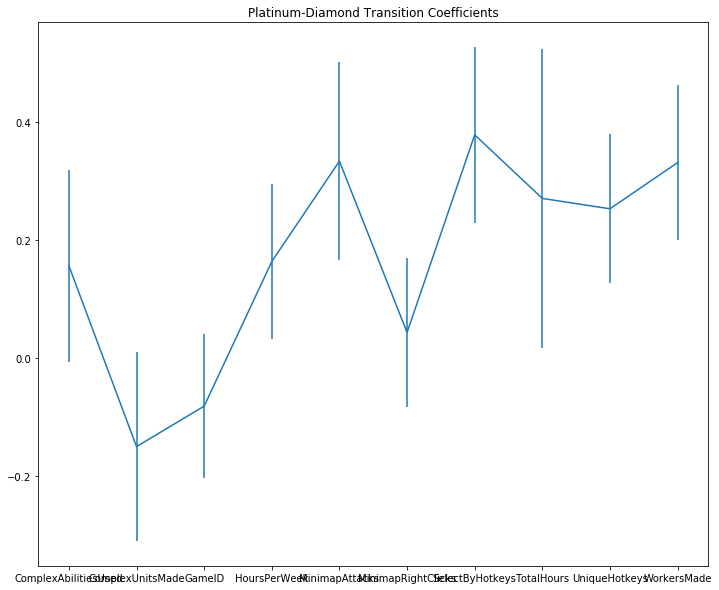

In [42]:
league45_build = confintcoeff_df[confintcoeff_df['LeagueName']=='45']
plt.figure(figsize=(12,10))
league45_coeff_plot = plt.errorbar(league45_build['Variables'],league45_build['Parameter Coefficients'],
                             yerr = [league45_build['lower'], league45_build['upper']])
league45_coeff_plot = plt.title('Platinum-Diamond Transition Coefficients')

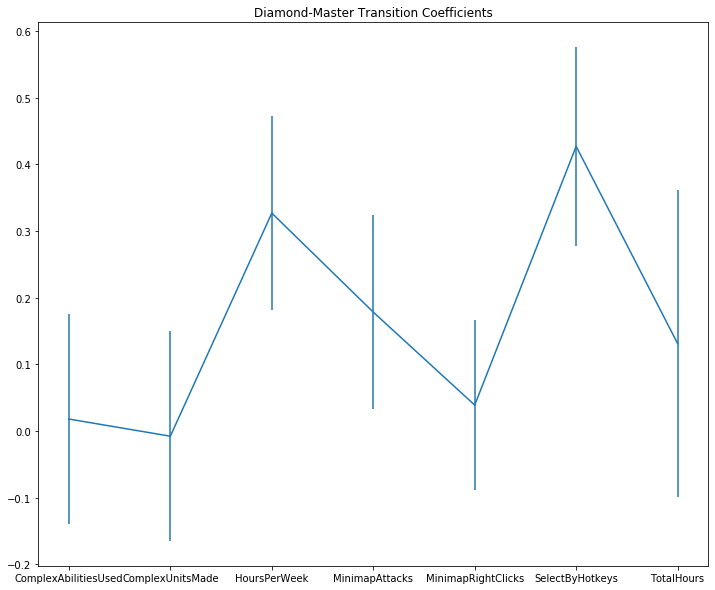

In [43]:
league56_build = confintcoeff_df[confintcoeff_df['LeagueName']=='56']
plt.figure(figsize=(12,10))
league56_coeff_plot = plt.errorbar(league56_build['Variables'],league56_build['Parameter Coefficients'],
                             yerr = [league56_build['lower'], league56_build['upper']])
league56_coeff_plot = plt.title('Diamond-Master Transition Coefficients')

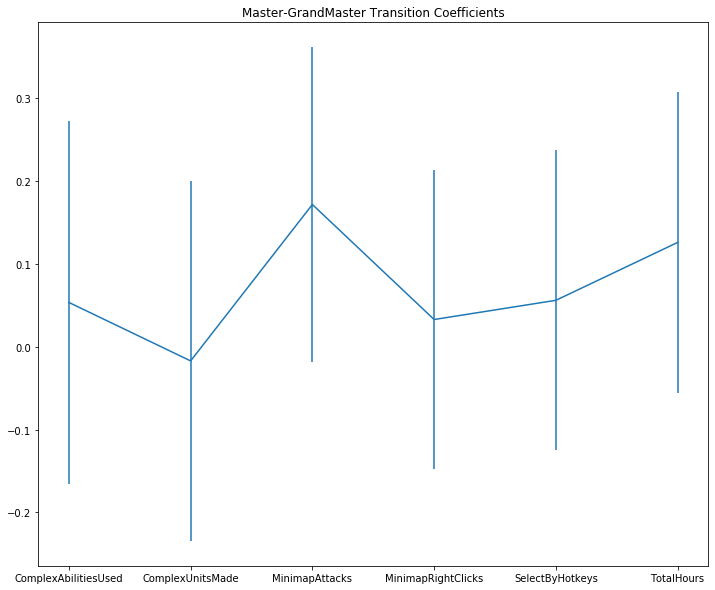

In [44]:
league67_build = confintcoeff_df[confintcoeff_df['LeagueName']=='67']
plt.figure(figsize=(12,10))
league67_coeff_plot = plt.errorbar(league67_build['Variables'],league67_build['Parameter Coefficients'],
                             yerr = [league67_build['lower'], league67_build['upper']])
league67_coeff_plot = plt.title('Master-GrandMaster Transition Coefficients')

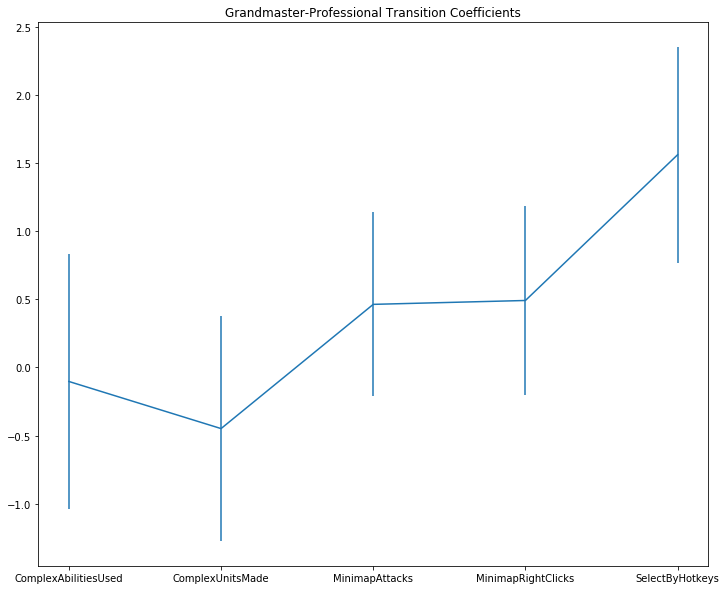

In [45]:
league78_build = confintcoeff_df[confintcoeff_df['LeagueName']=='78']
plt.figure(figsize=(12,10))
league78_coeff_plot = plt.errorbar(league78_build['Variables'],league78_build['Parameter Coefficients'],
                             yerr = [league78_build['lower'], league78_build['upper']])
league78_coeff_plot = plt.title('Grandmaster-Professional Transition Coefficients')

In [47]:
confintcoeff_df['param2']=abs(confintcoeff_df['Parameter Coefficients'])
confintcoeff_df['param3']=confintcoeff_df['param2']-confintcoeff_df['lower']
confintcoeff_df['Significance']=np.where(confintcoeff_df['param3']<0,0,confintcoeff_df['Parameter Coefficients'])
confintcoeff_df2 = confintcoeff_df.drop(['lower','upper','VIF','Parameter Coefficients','param2','param3'], axis=1)

,LeagueName,Variables,Significance
0,12,ComplexAbilitiesUsed,0.000000
1,12,ComplexUnitsMade,0.000000
2,12,HoursPerWeek,0.000000
3,12,MinimapAttacks,0.000000
4,12,MinimapRightClicks,0.263126


In [48]:
new_confint = confintcoeff_df2.pivot(index='Variables', columns='LeagueName', values='Significance')

LeagueName,12,23,34,45,56,67,78
Variables,,,,,,,
AssignToHotkeys,NaN,0.246798,NaN,NaN,NaN,NaN,NaN
ComplexAbilitiesUsed,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
ComplexUnitsMade,0.000000,0.000000,0.188254,0.000000,0.000000,0.0,0.000000
GameID,NaN,0.000000,NaN,0.000000,NaN,NaN,NaN
GapBetweenPACs,NaN,-0.280703,NaN,NaN,NaN,NaN,NaN
HoursPerWeek,0.000000,0.000000,0.000000,0.163595,0.326701,NaN,NaN
MinimapAttacks,0.000000,0.000000,0.000000,0.333933,0.178218,0.0,0.000000
MinimapRightClicks,0.263126,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
SelectByHotkeys,0.000000,0.251725,0.372702,0.378596,0.426766,0.0,1.560948


Text(0.5, 1, 'Significance of Coefficients of Variables')

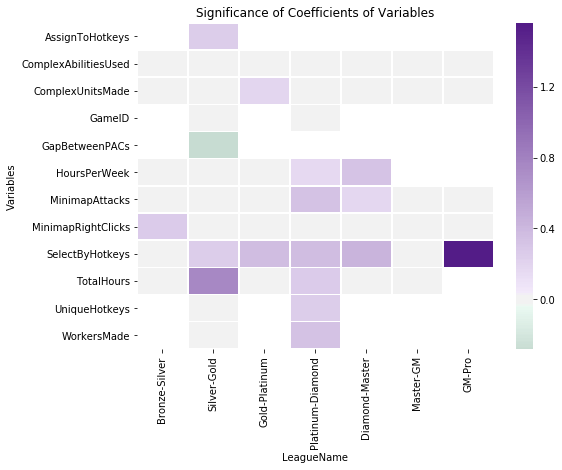

In [49]:
plt.figure(figsize=(8,6))
pal = sns.diverging_palette(145, 280, s=85, l=25, n=7, sep=5, as_cmap=True)
sns.heatmap(new_confint, center=0, cmap = pal,linewidths=.5, xticklabels=league_trans_name)
plt.title('Significance of Coefficients of Variables')

# PCA

In [50]:
def do_pca():
    variance_all = {}
    dimensions_all = {}
    for name in league_names:
        pca1 = PCA()
        pca1.fit(league_dict[name]['X_train'])
        variance = pca1.explained_variance_
        dimensions = np.arange(1,len(variance)+1)
        variance_all.update({name:variance})
        dimensions_all.update({name:dimensions})
        
    plt.figure(figsize=(12, 10))
    fig, axs = plt.subplots(3,3, figsize=(10,10))
    
    axs[0,0].plot(dimensions_all['12'],variance_all['12'], '-o')
    axs[0,0].set_title('Bronze-Silver')
    axs[0,1].plot(dimensions_all['23'],variance_all['23'], '-o')
    axs[0,1].set_title('Silver-Gold')
    axs[0,2].plot(dimensions_all['34'],variance_all['34'], '-o')
    axs[0,2].set_title('Gold-Platinum')
    axs[1,0].plot(dimensions_all['45'],variance_all['45'], '-o')
    axs[1,0].set_title('Platinum-Diamond')
    axs[1,1].plot(dimensions_all['56'],variance_all['56'], '-o')
    axs[1,1].set_title('Diamond-Master')
    axs[1,2].plot(dimensions_all['67'],variance_all['67'], '-o')
    axs[1,2].set_title('Master-Grandmaster')
    axs[2,1].plot(dimensions_all['78'],variance_all['78'], '-o')
    axs[2,1].set_title('Grandmaster-Professional')
    fig.suptitle('PCA of all Leagues')

<Figure size 864x720 with 0 Axes>

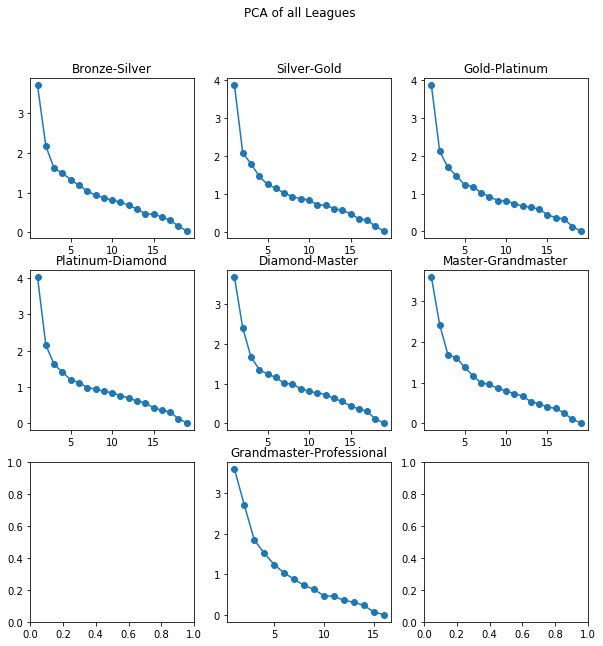

In [51]:
do_pca()

# Random Forest

In [52]:
#New dict for this chunk of analysis
#Note: drops the TotalHours, HoursPerWeek, and Age columns,
#since they are not contained in whole set, as well as any more NA values

forest_dict = {'full':base2.drop(['TotalHours','HoursPerWeek','Age'], axis=1).dropna(axis=0)}
forest_dict.update({'X':forest_dict['full'].drop(['LeagueIndex'],axis=1),
                    'y':forest_dict['full']['LeagueIndex']})
X_train_for, X_test_for, y_train_for, y_test_for = train_test_split(forest_dict['X'],forest_dict['y'])
forest_dict.update({'model_1':{'Desc':'All data modelled to the League Index',
                               'X_train':X_train_for,
                               'X_test':X_test_for,
                               'y_train':y_train_for,
                               'y_test':y_test_for}})

### Silver vs. Better (Boosting)

In [53]:
full_no_bronze = forest_dict['full'][forest_dict['full']['LeagueIndex']>=2]
for4_X = full_no_bronze.drop(['LeagueIndex'],axis=1)
for4_y = full_no_bronze['LeagueIndex']

In [54]:
for4_y.describe()

count    3227.000000
mean        4.348621
std         1.367500
min         2.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         8.000000
Name: LeagueIndex, dtype: float64

In [55]:
X_train_for4, X_test_for4, y_train_for4, y_test_for4 = train_test_split(for4_X,for4_y, random_state=0)
forest_dict.update({'model_4':{'Desc':'Silver vs Better',
                               'X_train':X_train_for4,
                               'X_test':X_test_for4,
                               'y_train':y_train_for4,
                               'y_test':y_test_for4}})

In [56]:
forest_dict['model_4']['y_train']=forest_dict['model_4']['y_train'].apply(lambda x: 1 if x>2 else 0)
forest_dict['model_4']['y_test']=forest_dict['model_4']['y_test'].apply(lambda x: 1 if x>2 else 0)

In [57]:
#standardscaler the whole thing
scaler4 = StandardScaler()
col_name4 = forest_dict['model_4']['X_train'].columns
xtrain4 = scaler4.fit_transform(forest_dict['model_4']['X_train'])
xtest4 = scaler4.transform(forest_dict['model_4']['X_test'])
#fit the model via Grid Search

forest_gsc_model_4 = GridSearchCV(estimator = RandomForestClassifier(),
                                 param_grid = {'max_depth':np.arange(3,8),
                                               'n_estimators':[110,120,130,140,150,160,170,180,190]},
                                 cv=5,
                                 scoring='roc_auc')
grid_result_4 = forest_gsc_model_4.fit(xtrain4,forest_dict['model_4']['y_train'])
best_params_4 = grid_result_4.best_params_

In [58]:
final_forest_model_4 = RandomForestClassifier(max_depth=best_params_4['max_depth'],
                                             n_estimators=best_params_4['n_estimators'])
final_forest_model_4.fit(xtrain4,forest_dict['model_4']['y_train'])
best_params_4
scores4=cross_val_score(final_forest_model_4, xtrain4,forest_dict['model_4']['y_train'],
                      cv=5, scoring='f1')
scores4

array([0.94644809, 0.94505495, 0.94644809, 0.94310722, 0.94260486])

In [59]:
best_params_4

{'max_depth': 5, 'n_estimators': 170}

In [60]:
pred4 = final_forest_model_4.predict(xtest4)
pd.crosstab(forest_dict['model_4']['y_test'],pred4)

col_0,0,1
LeagueIndex,,
0,12,83
1,5,707


In [61]:
pred4_2 = final_forest_model_4.predict(xtrain4)
pd.crosstab(forest_dict['model_4']['y_train'],pred4_2)

col_0,0,1
LeagueIndex,,
0,55,197
1,1,2167


#### Use the predicted probability to threshold for the best possible f1 score (or fbeta, depending on situation)

In [62]:
for_pred_proba_df=pd.DataFrame(final_forest_model_4.predict_proba(xtest4))
forest_threshold = np.arange(0, 1.01, 0.01)
best_fbeta = 0
best_threshold_for = 0
threshold_for = []
fbeta_scores = []
for i in forest_threshold:
    Y_test_pred_for = pd.DataFrame(for_pred_proba_df[1]).applymap(lambda x: 1 if x>i else 0)
    test_fbeta = fbeta_score(Y_test_pred_for, forest_dict['model_4']['y_test'], beta=3)
    threshold_for.append(i)
    fbeta_scores.append(test_fbeta)
    if test_fbeta>best_fbeta :
        best_threshold_for = i
        best_fbeta = test_fbeta
print('\n Best Threshold at {0} with an F-beta of 3 and an F-beta score of {1}'.format(best_threshold_for, best_fbeta))


 Best Threshold at 0.9 with an F-beta of 3 and an F-beta score of 0.9485144860675401


C:\Users\sagun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Text(0, 0.5, 'F-beta score')

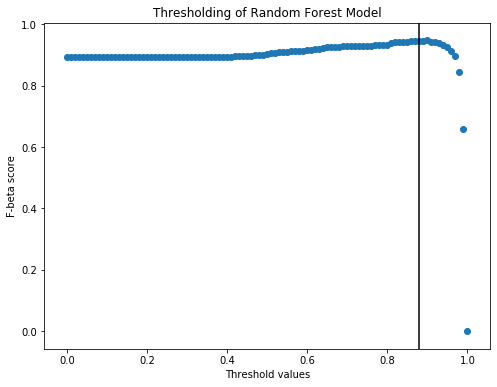

In [63]:
plt.figure(figsize=(8, 6))
plt.scatter(threshold_for,fbeta_scores)
plt.axvline(0.88, color='black')
plt.title('Thresholding of Random Forest Model')
plt.xlabel('Threshold values')
plt.ylabel('F-beta score')

Use best threshold on predicted probability in order to get new crosstab

In [64]:
pred4_3 = final_forest_model_4.predict_proba(xtrain4)
pred4_3 = pred4_3[:,1]
for i in np.arange(0,len(pred4_3)):
    if pred4_3[i]>0.78:
        pred4_3[i]=1
    else :
        pred4_3[i]=0
pd.crosstab(forest_dict['model_4']['y_train'],pred4_3)

col_0,0.0,1.0
LeagueIndex,,
0,193,59
1,190,1978


In [65]:
pred4_4 = final_forest_model_4.predict_proba(xtest4)
pred4_4 = pred4_4[:,1]
for i in np.arange(0,len(pred4_4)):
    if pred4_4[i]>best_threshold_for:
        pred4_4[i]=1
    else :
        pred4_4[i]=0
pd.crosstab(forest_dict['model_4']['y_test'],pred4_4)

col_0,0.0,1.0
LeagueIndex,,
0,86,9
1,198,514


#### Use the same dataset as above to do Logistic Regression and KNN Means, check results

Logitistic Regression

In [66]:
#start with VIF, so that the coefficients have meaning!
[variance_inflation_factor(pd.DataFrame(xtrain4).values, i) for i in range(pd.DataFrame(xtrain4).shape[1])]

[2.175527580115337,
 1.050571611456451,
 39.09097480422283,
 15.104498067192438,
 1.6528093380766473,
 1.3287902318802864,
 1.1359277658786369,
 1.2600159089442944,
 12.805832169181311,
 5.155628197469689,
 7.443227405615031,
 1.8133036041125743,
 1.2772506671055677,
 1.6320359936549818,
 1.810001090561249,
 1.6873354882745728]

In [67]:
xtrain4_2 = np.delete(xtrain4, [2,8],axis=1)
[variance_inflation_factor(pd.DataFrame(xtrain4_2).values, i) for i in range(pd.DataFrame(xtrain4_2).shape[1])]
xtest4_2 = np.delete(xtest4, [2,8], axis=1)

In [68]:
final_4_reg = sm.Logit(endog=forest_dict['model_4']['y_train'],exog=xtrain4_2)

In [69]:
result_final4 = final_4_reg.fit(method='newton',maxiter=100)

Optimization terminated successfully.
         Current function value: 0.662781
         Iterations 5


In [70]:
pred_final4_lr = pd.DataFrame(final_4_reg.predict(result_final4.params, exog=xtest4_2))

In [71]:
threshold_list_4lr = np.arange(0,1.01,0.01)
best_threshold_4lr = 0
best_accuracy_4lr=0
for i in threshold_list_4lr:
    Y_test_pred_4lr = pred_final4_lr.applymap(lambda x: 1 if x>i else 0)
    test_accuracy_4lr = fbeta_score(Y_test_pred_4lr, forest_dict['model_4']['y_test'], beta=3)
    if test_accuracy_4lr>best_accuracy_4lr :
        best_threshold_4lr = i
        best_accuracy_4lr = test_accuracy_4lr
        print('\n Best Threshold at {0} with an Accuracy of {1}'.format(best_threshold_4lr, best_accuracy_4lr))


 Best Threshold at 0.0 with an Accuracy of 0.8927899686520376

 Best Threshold at 0.1 with an Accuracy of 0.8948096016086465

 Best Threshold at 0.11 with an Accuracy of 0.8958228485153498

 Best Threshold at 0.13 with an Accuracy of 0.8968383927446781

 Best Threshold at 0.14 with an Accuracy of 0.8978562421185372

 Best Threshold at 0.15 with an Accuracy of 0.8998988877654196

 Best Threshold at 0.16 with an Accuracy of 0.9009236998608122

 Best Threshold at 0.18 with an Accuracy of 0.9014728288471305

 Best Threshold at 0.2 with an Accuracy of 0.9032997834118995

 Best Threshold at 0.21 with an Accuracy of 0.9059456688877499

 Best Threshold at 0.22 with an Accuracy of 0.9078050662209078

 Best Threshold at 0.23 with an Accuracy of 0.9086222451346824

 Best Threshold at 0.24 with an Accuracy of 0.9092084842214174

 Best Threshold at 0.25 with an Accuracy of 0.9101577780675448

 Best Threshold at 0.26 with an Accuracy of 0.9109920271859887

 Best Threshold at 0.27 with an Accuracy o

C:\Users\sagun\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


In [72]:
result_final4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            LeagueIndex   No. Observations:                 2420
Model:                          Logit   Df Residuals:                     2406
Method:                           MLE   Df Model:                           13
Date:                Mon, 16 Dec 2019   Pseudo R-squ.:                 -0.9840
Time:                        09:04:40   Log-Likelihood:                -1603.9
converged:                       True   LL-Null:                       -808.45
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1198      0.063     -1.911      0.056      -0.243       0.003
x2            -0.0158      0.043     -0.368      0.713      -0.100       0.068
x3             0.0066      0.051      0.130      0.897      -0.093       0.106
x4             0.0872      0.054      1.613      0.107      -0.019       0.193
x5             0.0216      0.048      0.448      0.654      -0.073       0.116
x6             0.0366      0.045      0.806      0.420      -0.052       0.125
x7            -0.0138      0.047     -0.296      0.767      -0.106       0.078
x8            -0.3413      0.068     -5.020      0.000      -0.475      -0.208
x9            -0.0065      0.050     -0.131      0.896      -0.104       0.091
x10           -0.0526      0.055     -0.951      0.342      -0.161       0.056
x11            0.0655      0.046      1.435      0.151      -0.024       0.155
x12            0.0398      0.054      0.742      0.458      -0.065       0.145
x13            0.0783      0.056      1.388      0.165      -0.032       0.189
x14           -0.0116      0.054     -0.214      0.830      -0.118       0.095
==============================================================================
"""

KNN Means

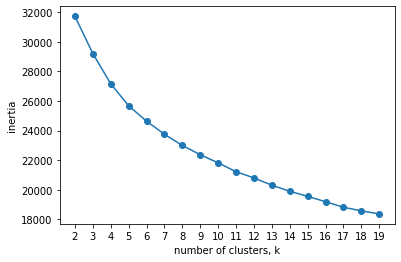

In [73]:
from sklearn.cluster import KMeans
ks = np.arange(2,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(xtrain4)
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

From the above, we can see that the data doesn't have a clear elbow to chose for clusters, but rather a nice curve, making the choice a clusters fairly arbitrary. I will be choosing 6 to start

In [74]:
model6 = KMeans(n_clusters=6)
model6.fit(xtrain4)
labels6 = model6.predict(xtrain4)

In [75]:
pca_for4 = PCA(n_components=2)

features = pca_for4.fit_transform(xtrain4)
x = features[:,0]
y = features[:,1]
names = forest_dict['model_4']['X_train'][forest_dict['model_4']['X_train'].columns[0]]

labelsdf = pd.DataFrame(labels6)

xdf = pd.DataFrame(x)
ydf = pd.DataFrame(y)

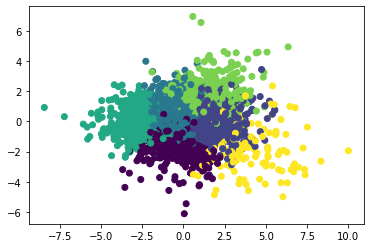

In [76]:
plt.scatter(x,y,c=labels6)

Now run with the 2 groups that are expected of the data

In [77]:
pca_for2 = PCA(n_components=2)

features2 = pca_for2.fit_transform(xtest4)
x2 = features2[:,0]
y2 = features2[:,1]
model2 = KMeans(n_clusters=2)
model2.fit(xtrain4)
labels2 = model2.predict(xtest4)

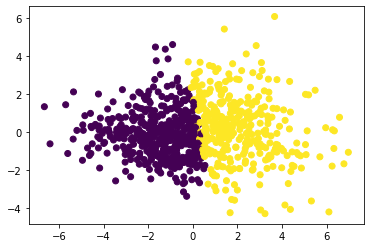

In [78]:
plt.scatter(x2,y2,c=labels2)

Neither set shows particularly good clustering, either at the 2 group level expected, or at the 6 groups that may fit better. Due to that, KMeans is not a good strategy for categorizing this dataset.